## Moving Average

#### Moving Average is the technique we use to extract trend component of a timeseries 

* we can use `pandas rolling` method for this purpose
* We need a window to compute moving average
* We can smooth out the seasonal variation by using a window = seasonal period
* The window size can be odd or even
* If the size is odd, we can compute mean at the center of window
* If the size is even, we have to apply an additional 2-MA to get the results



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data

In [6]:
df = pd.read_csv('../../Datasets/example_retail_sales.csv', index_col='ds', parse_dates=['ds'])
df.head()

,y
ds,
1992-01-01,146376
1992-02-01,147079
1992-03-01,159336
1992-04-01,163669
1992-05-01,170068


#### We have monthly data with a yearly seasonality

a pattern which repeats every 12 periods

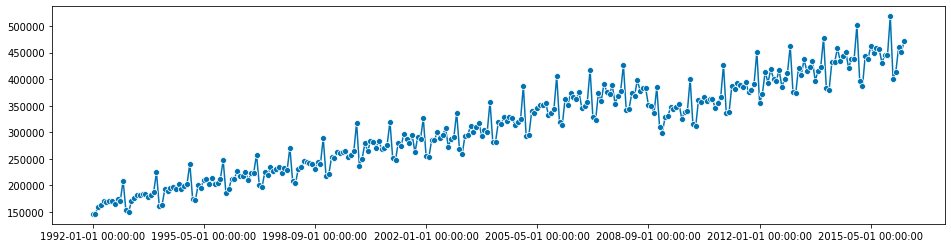

In [9]:
from sktime.utils.plotting import plot_series

plot_series(df);

## Moving average  window = 3 (odd)

* Since we have odd window size , we can compute the mean at the center of the window
* If window size is not odd, donot use `center = True`. It would give us incorrect results


In [18]:
# # Compute average at center of window
data = df.rolling(window=3, center=True).mean() 

data.rename(columns={'y':'MA-3'}, inplace=True)

data

,MA-3
1992-01-01,NaN
1992-02-01,150930.333333
1992-03-01,156694.666667
1992-04-01,164357.666667
1992-05-01,167466.666667
...,...
2016-01-01,444245.000000
2016-02-01,424858.333333
2016-03-01,441527.333333
2016-04-01,460816.333333


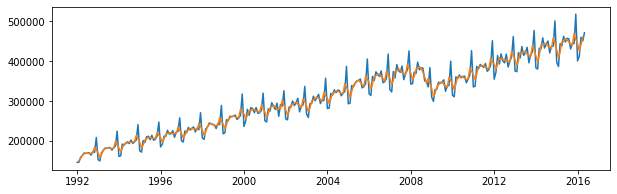

In [23]:
# visual
plt.figure(figsize=(10,3))
plt.plot(df)
plt.plot(data);

#### We can see that a moving average of order 3 smooths the data, however, is still impacted by the seasonality in the data.

#### We can smooth the seasonal variation by choosing a window equal to the seasonal period


#### Here we have monthly data with yearly seasonality

#### SP = 12

## Moving average with even window 


#### `df.rolling(window=4, center=True).mean()`
#### This does not give the correct answer in Pandas


In [60]:
temp = df.rolling(window=4, center=True).mean()

temp.rename(columns={'y':'MA-4 wrong'}, inplace=True)

temp

,MA-4 wrong
1992-01-01,NaN
1992-02-01,NaN
1992-03-01,154115.00
1992-04-01,160038.00
1992-05-01,165434.00
...,...
2016-01-01,444310.50
2016-02-01,448207.00
2016-03-01,431377.50
2016-04-01,449000.75


## How we get the correct MA 

In [73]:

weights = [1/8, 1/4, 1/4, 1/4, 1/8]
values = df.values
# this is what should be the first result

result = [(weights@values[i:i+5]).flatten()[0] for i in range(df.shape[0]-4)]

In [74]:
padding = [np.nan for i in range(2)]
result = padding + result + padding

In [77]:
temp['correction'] = result

temp

,MA-4 wrong,correction
1992-01-01,NaN,NaN
1992-02-01,NaN,NaN
1992-03-01,154115.00,157076.500
1992-04-01,160038.00,162736.000
1992-05-01,165434.00,166753.250
...,...,...
2016-01-01,444310.50,446258.750
2016-02-01,448207.00,439792.250
2016-03-01,431377.50,440189.125
2016-04-01,449000.75,NaN


## Even window and pandas rolling method

In [81]:
temp['MA-4 correct']=(df.rolling(window=4).mean() # dont use center = True
.rolling(window=2).mean() # dont use center = True
.shift(periods=-2)) # shift backwards to align the index

# shift = window-size//2  here 4//2 = 2

In [82]:
temp

,MA-4 wrong,correction,MA-4 correct
1992-01-01,NaN,NaN,NaN
1992-02-01,NaN,NaN,NaN
1992-03-01,154115.00,157076.500,157076.500
1992-04-01,160038.00,162736.000,162736.000
1992-05-01,165434.00,166753.250,166753.250
...,...,...,...
2016-01-01,444310.50,446258.750,446258.750
2016-02-01,448207.00,439792.250,439792.250
2016-03-01,431377.50,440189.125,440189.125
2016-04-01,449000.75,NaN,NaN


## Why are we shifting?? 

In [98]:
window_size=4
sample = df.copy()
sample[f'MA-{window_size}'] = df.rolling(window=window_size).mean()
sample[f'MA-2X4'] = sample['MA-4'].rolling(window=2).mean()
# to align the index we have to shift backwards by window-size//2
sample['MA-4 correct'] = sample['MA-2X4'].shift(periods=-window_size//2)

In [99]:
sample

,y,MA-4,MA-2X4,MA-4 correct
1992-01-01,146376,NaN,NaN,NaN
1992-02-01,147079,NaN,NaN,NaN
1992-03-01,159336,NaN,NaN,157076.500
1992-04-01,163669,154115.00,NaN,162736.000
1992-05-01,170068,160038.00,157076.500,166753.250
...,...,...,...,...
2016-01-01,400928,452161.75,455910.375,446258.750
2016-02-01,413554,444310.50,448236.125,439792.250
2016-03-01,460093,448207.00,446258.750,440189.125
2016-04-01,450935,431377.50,439792.250,NaN


## Visualize

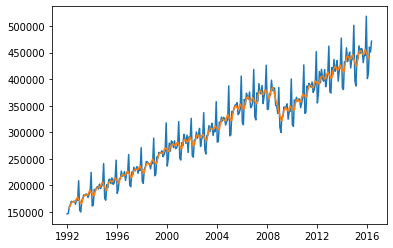

In [101]:
plt.plot(df)
plt.plot(sample['MA-4 correct']);

#### By using a window size = seasonal periodicity we can smooth out the variation

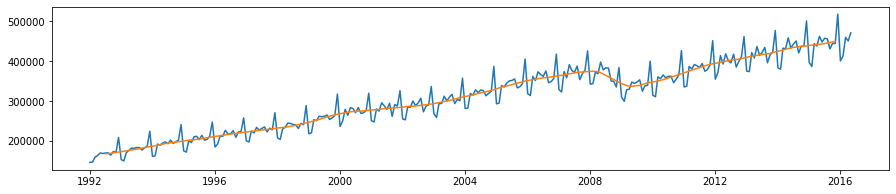

In [108]:
sp = 12
MA_SP = df.rolling(window=sp).mean().rolling(window=2).mean().shift(periods=-sp//2)

plt.figure(figsize=(15,3))
plt.plot(df)
plt.plot(MA_SP);